In [ ]:
from pathlib import Path
import json
import os
import joblib
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis, pearsonr
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV


In [3]:
# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Load Data and create Features

In [155]:
## Load data

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]
        
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)

    return main_df



df = format_data(True)

In [ ]:
def extract_time_features(signal):
    """Extract time domain features from a signal."""
    features = {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'min': float(np.min(signal)),
        'max': float(np.max(signal)),
        'ptp': float(np.ptp(signal)),
        'skew': float(skew(signal)),
        'kurtosis': float(kurtosis(signal)),
        'rms': float(np.sqrt(np.mean(signal**2))),
        'median': float(np.median(signal))
    }
    return features

def extract_frequency_features(signal):
    """Extract frequency domain features from a signal."""
    features = {}
    
    # Calculate power spectral density
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)
    
    # Define sleep frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }
    
    # Calculate power in each band
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        if np.any(band_mask):
            band_power = np.sum(psd[band_mask])
            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(band_power / total_power if total_power > 0 else 0)
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
    
    # Spectral edge frequency (95%)
    cumsum_psd = np.cumsum(psd)
    if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
        sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
        features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)
    
    features['total_power'] = float(total_power)
    return features

def extract_channel_features(channel_signal):
    """Extract all features for a single channel."""
    time_features = extract_time_features(channel_signal)
    freq_features = extract_frequency_features(channel_signal)
    return {**time_features, **freq_features}

def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features

def create_features(df):
    print(f"Processing {len(df)} epochs...")
    
    # Process each row to extract features
    all_features = []
    
    for i, row in df.iterrows():
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(df)} epochs")
        
        features = process_single_epoch(row)
        all_features.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    
    # Add temporal context
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df)
    
    return features_df


# Create the submission file
def create_submission(df_test, predictions):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv('submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission





df_features = create_features(df)

Processing 7433 epochs...
  Progress: 0/7433 epochs
  Progress: 100/7433 epochs
  Progress: 200/7433 epochs
  Progress: 300/7433 epochs
  Progress: 400/7433 epochs
  Progress: 500/7433 epochs
  Progress: 600/7433 epochs
  Progress: 700/7433 epochs
  Progress: 800/7433 epochs
  Progress: 900/7433 epochs
  Progress: 1000/7433 epochs
  Progress: 1100/7433 epochs
  Progress: 1200/7433 epochs
  Progress: 1300/7433 epochs
  Progress: 1400/7433 epochs
  Progress: 1500/7433 epochs
  Progress: 1600/7433 epochs
  Progress: 1700/7433 epochs
  Progress: 1800/7433 epochs
  Progress: 1900/7433 epochs
  Progress: 2000/7433 epochs
  Progress: 2100/7433 epochs
  Progress: 2200/7433 epochs
  Progress: 2300/7433 epochs
  Progress: 2400/7433 epochs
  Progress: 2500/7433 epochs
  Progress: 2600/7433 epochs
  Progress: 2700/7433 epochs
  Progress: 2800/7433 epochs
  Progress: 2900/7433 epochs
  Progress: 3000/7433 epochs
  Progress: 3100/7433 epochs
  Progress: 3200/7433 epochs
  Progress: 3300/7433 epochs


C:\Users\mathias\AppData\Local\Temp\ipykernel_8200\1540461035.py:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


## Data exploration

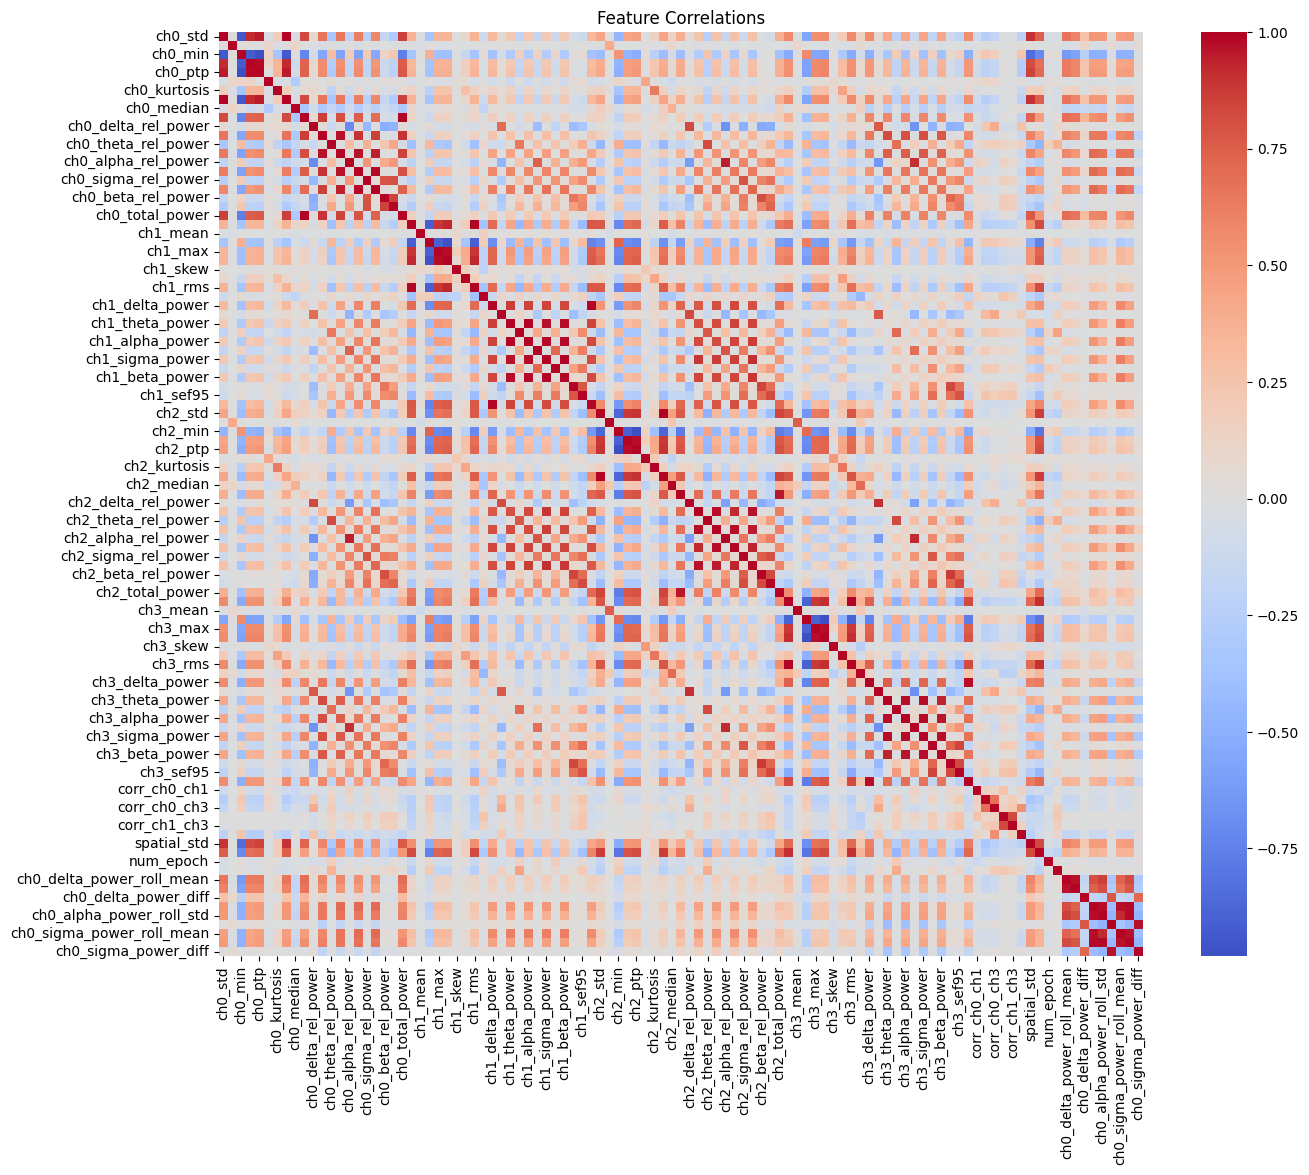

In [178]:
# Plot correlation heatmap
plt.figure(figsize=(15, 12))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# Find highly correlated pairs (> 0.8 or <-0.8)
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

In [180]:
def remove_correlated(df, high_corr, threshold=0.85):
    """Remove highly correlated features from DataFrame."""
    
    # Get features to drop
    to_drop = set()
    
    for f1, f2, corr in high_corr:
        if abs(corr) > threshold:
            # Drop the second feature in each pair
            to_drop.add(f2)
    
    # Remove features
    df_clean = df.drop(columns=list(to_drop))
    
    print(f"Dropped {len(to_drop)} features")
    print(f"Before: {df.shape}, After: {df_clean.shape}")
    
    return df_clean, list(to_drop)


df_clean, dropped = remove_correlated(df_features, high_corr, threshold=0.85)

Dropped 46 features
Before: (7433, 103), After: (7433, 57)


## Build Model

In [183]:
X_df, y = df_clean.drop(['num_signal'], axis=1), df['target']


# 1. Split first
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=RANDOM_STATE)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Handle class imbalance (Stage N1 is rare!)
sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model.predict(X_test)


f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_weighted = f1_score(y_test, predictions, average='weighted')

print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

Macro F1 Score: 0.8523
Micro F1 Score: 0.9059
Weighted F1 Score: 0.9024


In [ ]:
# Grid serach to find the best XG boost classifier

# param_dist = {
#     'n_estimators': [300, 500, 700, 1000],
#     'max_depth': [5, 7, 9, 11],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
# }

# xgb_search = RandomizedSearchCV(
#     XGBClassifier(random_state=RANDOM_STATE),
#     param_dist,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=3,
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )

# xgb_search.fit(X_train, y_train, sample_weight=sample_weights)
# best_model = xgb_search.best_estimator_

# # Save the model and the scaler
# joblib.dump(best_model, 'best_xgboost_model.joblib')
# joblib.dump(scaler, 'scaler.joblib')


best_model = joblib.load('best_xgboost_model.joblib')
scaler = joblib.load('scaler.joblib')

predictions = best_model.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=RANDOM_STATE)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_weighted = f1_score(y_test, predictions, average='weighted')

print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")


# Create submission using data
df_test = format_data(False)
X_df_test = create_features(df_test)
X_test = scaler.transform(X_df_test.drop('num_signal', axis=1))


predictions = best_model.predict(X_test)
sub = create_submission(df_test, predictions)
